<a href="https://colab.research.google.com/github/jasonbuchanan145/Data-Modeling/blob/main/insPLAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detection of damaged power infastructure using Neural Networks and Multihead Classification  

Jason Buchanan

Lakshmi Varaha Krishna Chittella

Uses the Insplad Dataset and builds a two head model for object detection of damaged power infastructure

Detection of degraded electrical tower components

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
from typing import Tuple
from sklearn.utils.class_weight import compute_class_weight
from torchsummary import summary
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle
import json

In [24]:
# Define the path to the dataset
from google.colab import drive
import os
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/insplad'
base_path = f'{root_path}/defect_supervised'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loader class. Traverse the directory structure of the dataset and set it as classes for two stage classification

In [25]:
class InsPLADDataset(Dataset):
    def __init__(self, root_dir: str, split: str = 'train', transform=None):
        """
        Args:
            root_dir (str): Root directory containing class folders
            split (str): 'train' or 'val'
            transform: transform to be applied to images
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        # Get all main classes (top level directories)
        self.main_classes = [d for d in os.listdir(root_dir)
                           if os.path.isdir(os.path.join(root_dir, d))]

        # Initialize structures to track both main classes and subclasses
        self.main_class_to_idx = {cls: idx for idx, cls in enumerate(self.main_classes)}
        self.subclasses = {}  # Dictionary to store subclasses for each main class

        self.hierarchical_subclass_to_idx = {}  # Maps (main_class, subclass) pairs to unique indices
        self.idx_to_hierarchical_subclass = {}  # Reverse mapping for easy lookup

        self.samples = []  # Will store paths and both levels of classes

        global_subclass_idx = 0

        # Walk through the directory structure
        for main_class in self.main_classes:
            main_class_dir = os.path.join(root_dir, main_class)
            split_dir = os.path.join(main_class_dir, split)

            # Get subclasses for this main class
            self.subclasses[main_class] = []

            for subclass in os.listdir(split_dir):
                subclass_dir = os.path.join(split_dir, subclass)
                if os.path.isdir(subclass_dir):
                    # Create hierarchical key
                    hierarchical_key = (main_class, subclass)

                    # Add subclass to tracking structures
                    self.subclasses[main_class].append(subclass)

                    # Map the hierarchical pair to a unique index
                    if hierarchical_key not in self.hierarchical_subclass_to_idx:
                        self.hierarchical_subclass_to_idx[hierarchical_key] = global_subclass_idx
                        self.idx_to_hierarchical_subclass[global_subclass_idx] = hierarchical_key
                        global_subclass_idx += 1

                    # Get all images in the subclass directory
                    for img_name in os.listdir(subclass_dir):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            img_path = os.path.join(subclass_dir, img_name)
                            self.samples.append({
                                'path': img_path,
                                'main_class': main_class,
                                'subclass': subclass,
                                'main_class_idx': self.main_class_to_idx[main_class],
                                'hierarchical_idx': self.hierarchical_subclass_to_idx[hierarchical_key]
                            })

    def get_class_distributions(self):
        """Calculate detailed distribution of samples across classes and subclasses."""
        main_class_dist = {}
        hierarchical_subclass_dist = {}
        hierarchical_dist = {}

        for sample in self.samples:
            main_class = sample['main_class']
            subclass = sample['subclass']
            hierarchical_key = (main_class, subclass)

            # Update main class counts
            main_class_dist[main_class] = main_class_dist.get(main_class, 0) + 1

            # Update hierarchical subclass counts
            hierarchical_subclass_dist[hierarchical_key] = hierarchical_subclass_dist.get(hierarchical_key, 0) + 1

            # Update hierarchical counts
            if main_class not in hierarchical_dist:
                hierarchical_dist[main_class] = {}
            hierarchical_dist[main_class][subclass] = hierarchical_dist[main_class].get(subclass, 0) + 1

        return {
            'main_classes': main_class_dist,
            'hierarchical_subclasses': hierarchical_subclass_dist,
            'hierarchical': hierarchical_dist
        }
    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, int]:
        """
        Returns:
            tuple: (image, main_class_target, hierarchical_subclass_target)
        """
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, sample['main_class_idx'], sample['hierarchical_idx']
    def get_class_info(self):
        """Returns detailed information about the dataset structure with counts."""
        info = {
            'num_main_classes': len(self.main_classes),
            'num_total_subclasses': len(self.hierarchical_subclass_to_idx),
            'main_classes': self.main_classes,
            'subclasses_per_main': self.subclasses,
            'hierarchical_mapping': self.hierarchical_subclass_to_idx,
            'class_distributions': self.get_class_distributions()
        }
        return info

Exploration class for the data once loaded

In [26]:
from prettytable import PrettyTable
def print_dataset_statistics(data_dir: str, split: str = 'train'):
    """Print detailed dataset statistics using PrettyTable."""
    dataset = InsPLADDataset(data_dir, split)
    info = dataset.get_class_info()
    distributions = info['class_distributions']

    # Create summary table
    summary_table = PrettyTable()
    summary_table.title = f"Dataset Summary ({split})"
    summary_table.field_names = ["Metric", "Value"]
    summary_table.align["Metric"] = "l"  # Left align text
    summary_table.align["Value"] = "r"   # Right align numbers

    total_images = sum(distributions['main_classes'].values())
    summary_table.add_rows([
        ["Total Images", total_images],
        ["Main Classes", info['num_main_classes']],
        ["Total Subclasses", info['num_total_subclasses']]
    ])
    print(summary_table)

    # Create detailed distribution table
    dist_table = PrettyTable()
    dist_table.title = "Class Distribution"
    dist_table.field_names = ["Main Class", "Subclass", "Images", "% of Class", "% of Total"]
    dist_table.align = "l"  # Left align all columns
    dist_table.align["Images"] = "r"     # Right align numbers
    dist_table.align["% of Class"] = "r"
    dist_table.align["% of Total"] = "r"

    for main_class in info['main_classes']:
        main_class_count = distributions['main_classes'][main_class]
        subclasses = info['subclasses_per_main'][main_class]

        # Add a row for each subclass
        for subclass in subclasses:
            subclass_count = distributions['hierarchical'][main_class][subclass]
            class_percentage = (subclass_count / main_class_count) * 100
            total_percentage = (subclass_count / total_images) * 100

            dist_table.add_row([
                main_class if subclass == subclasses[0] else "",  # Only show main class once
                subclass,
                subclass_count,
                f"{class_percentage:.1f}%",
                f"{total_percentage:.1f}%"
            ])

        # Add a separator between main classes
        if main_class != info['main_classes'][-1]:
            dist_table.add_row(["-" * len(main_class), "-" * 10, "-" * 6, "-" * 8, "-" * 8])

    print("\n" + str(dist_table))

In [27]:
def explore_dataset(data_dir):
    # Create dataset instance
    dataset = InsPLADDataset(data_dir, 'train')

    # Get and print dataset information
    info = dataset.get_class_info()

    print(f"Dataset Structure:")
    print(f"Number of main classes: {info['num_main_classes']}")
    print(f"Total number of subclasses: {info['num_total_subclasses']}")
    print("\nMain classes and their subclasses:")
    for main_class, subclasses in info['subclasses_per_main'].items():
        print(f"\n{main_class}:")
        for subclass in subclasses:
            count = info['class_distributions']['subclasses'].get(subclass, 0)
            print(f"  - {subclass}: {count} images")

    # Visualize class distributions
    plt.figure(figsize=(15, 5))

    # Main classes distribution
    main_counts = info['class_distributions']['main_classes']
    plt.bar(main_counts.keys(), main_counts.values())
    plt.title('Main Class Distribution')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

Data loader

In [28]:
def get_hierarchical_data_loaders(data_dir: str, batch_size: int = 256):
    """
    Creates data loaders with proper train/val split using the existing directory structure.
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Create separate datasets for train and val using the existing directory structure
    train_dataset = InsPLADDataset(data_dir, 'train', transform=transform)
    val_dataset = InsPLADDataset(data_dir, 'val', transform=transform)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    # Print dataset statistics
    print("\nDataset Statistics:")
    print("=" * 50)

    def print_split_stats(dataset, name):
        main_counts = {}
        sub_counts = {}

        for sample in dataset.samples:
            main_class = sample['main_class']
            sub_class = f"{main_class}/{sample['subclass']}"

            main_counts[main_class] = main_counts.get(main_class, 0) + 1
            sub_counts[sub_class] = sub_counts.get(sub_class, 0) + 1

        print(f"\n{name} Set:")
        print(f"Total samples: {len(dataset)}")
        print("\nMain class distribution:")
        for cls, count in main_counts.items():
            print(f"{cls}: {count}")
        print("\nSubclass distribution:")
        for cls, count in sub_counts.items():
            print(f"{cls}: {count}")

    print_split_stats(train_dataset, "Training")
    print_split_stats(val_dataset, "Validation")

    return train_loader, val_loader

Start running

Explore the dataset

helper functions

In [29]:
def explore_dataset(data_dir):
    """Explore and visualize dataset statistics."""
    # Print statistics for both splits
    for split in ['train', 'val']:
        print(f"\n{split.upper()} SET STATISTICS")
        print("=" * 80)
        print_dataset_statistics(data_dir, split)

    # Create visualization
    dataset = InsPLADDataset(data_dir, 'train')
    info = dataset.get_class_info()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Main class distribution
    main_counts = info['class_distributions']['main_classes']
    bars1 = ax1.bar(main_counts.keys(), main_counts.values())
    ax1.set_title('Distribution of Images Across Main Classes')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)


TRAIN SET STATISTICS
+--------------------------+
| Dataset Summary (train)  |
+------------------+-------+
| Metric           | Value |
+------------------+-------+
| Total Images     |  5108 |
| Main Classes     |     5 |
| Total Subclasses |    11 |
+------------------+-------+

+----------------------------------------------------------------------------------+
|                                Class Distribution                                |
+---------------------------------+-------------+--------+------------+------------+
| Main Class                      | Subclass    | Images | % of Class | % of Total |
+---------------------------------+-------------+--------+------------+------------+
| yoke-suspension                 | rust        |    290 |      49.2% |       5.7% |
|                                 | good        |    299 |      50.8% |       5.9% |
| ---------------                 | ----------  | ------ |   -------- |   -------- |
| glass-insulator                 | 

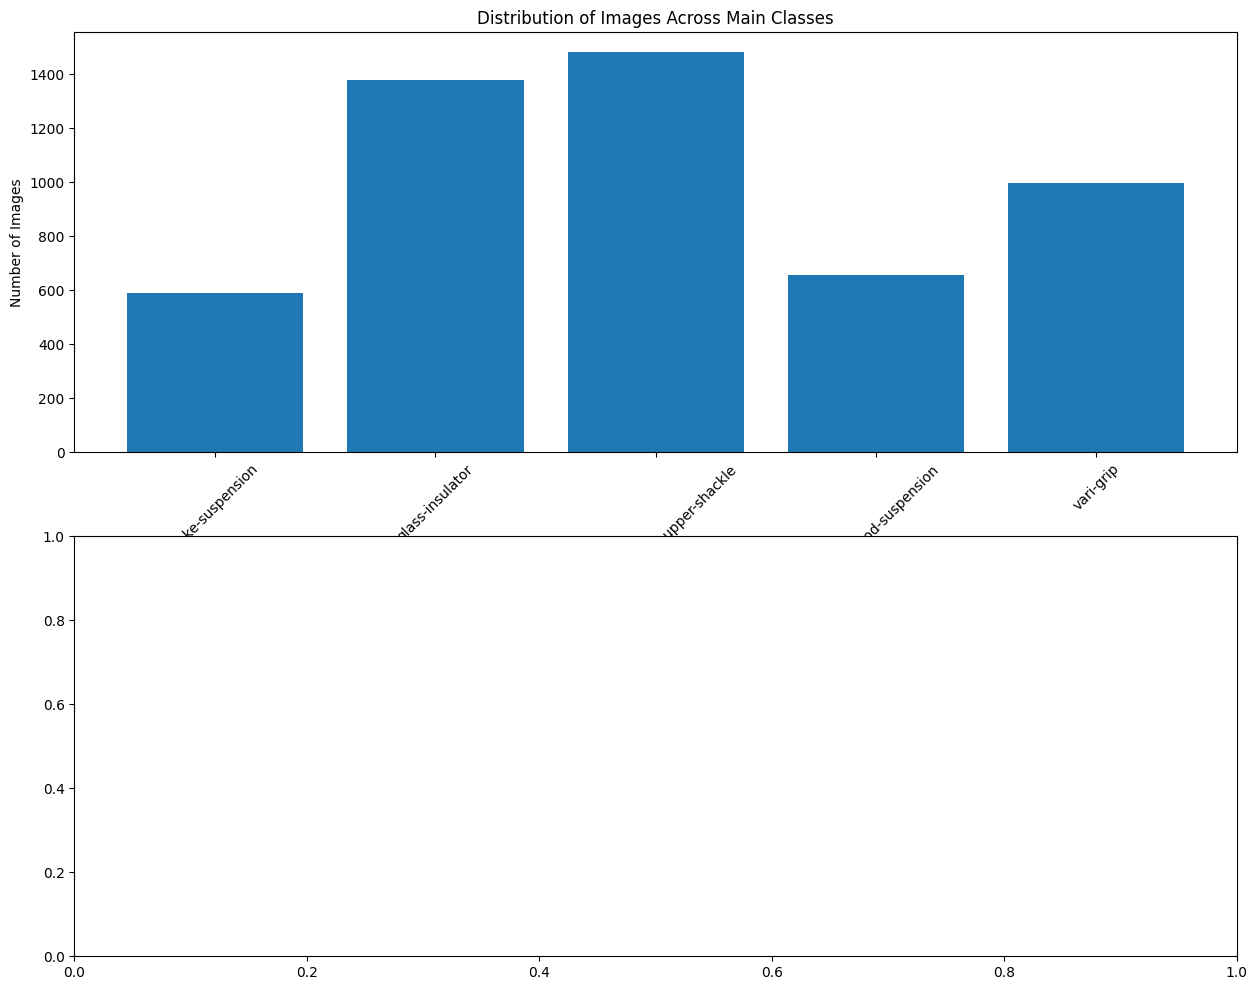

In [30]:
explore_dataset(base_path)

Save the metrics generated by two stage classifier since it's slow to run

In [31]:
def save_training_metrics(main_metrics, sub_metrics):
    save_dir = '/content/drive/MyDrive/insplad/report'
    os.makedirs(save_dir, exist_ok=True)
    # Save training metrics
    metrics = {
        'main_metrics': main_metrics,  # (train_losses, val_accuracies)
        'sub_metrics': sub_metrics     # Dict of metrics per main class
    }

    metrics_path = os.path.join(save_dir, 'training_metrics.pkl')
    with open(metrics_path, 'wb') as f:
        pickle.dump(metrics, f)

    print(f"Training metrics saved to {metrics_path}")

def load_training_metrics():
    """
    Load training metrics from Google Drive.

    Returns:
        tuple: (main_metrics, sub_metrics)
    """
    save_dir = '/content/drive/MyDrive/insplad/report'
    metrics_path = os.path.join(save_dir, 'training_metrics.pkl')
    with open(metrics_path, 'rb') as f:
        metrics = pickle.load(f)

    print(f"Training metrics loaded from {metrics_path}")
    return metrics['main_metrics'], metrics['sub_metrics']


Two stage classification

In [32]:
class TwoHeadModel(nn.Module):
    def __init__(self, feature_dim, num_main_classes, num_hierarchical_subclasses):
        super().__init__()

        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.base = nn.Sequential(
          *list(resnet.children())[:-2],  # Remove FC and pooling layers
          nn.AdaptiveAvgPool2d((1, 1)),
          nn.Flatten()
        )
        for param in self.base.parameters():
            param.requires_grad = False
        print("model fully connected")
        print(resnet.fc)
        self.feature_dim = feature_dim

        # Main classifier remains simple for coarse classification
        self.main_classifier = nn.Linear(feature_dim, num_main_classes)
        # Second branch - deeper network
        self.subclass_deep = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(feature_dim, feature_dim // 2),
            nn.BatchNorm1d(feature_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(feature_dim // 2, feature_dim // 4),
            nn.BatchNorm1d(feature_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(feature_dim // 4, num_hierarchical_subclasses)
        )
        self.subclass_deep.apply(self.init_weights)


    def init_weights(self, m):
        if isinstance(m, nn.Linear):
          nn.init.kaiming_normal_(m.weight)
          if m.bias is not None:
              nn.init.constant_(m.bias, 0)

    def forward(self, tensor, mode='main'):
        features = self.base(tensor)

        if mode == 'main':
            return self.main_classifier(features)

        elif mode == 'both':
            main_out = self.main_classifier(features)
            sub_out = self.subclass_deep(features)
            return main_out, sub_out
        else:  # subclass mode
            sub_out = self.subclass_deep(features)
            return sub_out

In [33]:
class HierarchicalClassifier:
    def __init__(self, device: torch.device):
        self.device = device
        self.model = None
        # Initialize all mappings as None
        self.main_class_to_idx = None
        self.idx_to_main = None
        self.hierarchical_subclass_to_idx = None
        self.idx_to_hierarchical_subclass = None
        self.save_dir = '/content/drive/MyDrive/insplad/models'
        os.makedirs(self.save_dir, exist_ok=True)

    def create_model(self, train_loader):
      """Initialize model and store class mappings."""
      # Store class mappings from dataset
      self.main_class_to_idx = train_loader.dataset.main_class_to_idx
      self.hierarchical_subclass_to_idx = train_loader.dataset.hierarchical_subclass_to_idx
      self.idx_to_hierarchical_subclass = train_loader.dataset.idx_to_hierarchical_subclass

      # Create reverse mapping for main classes
      self.idx_to_main = {v: k for k, v in self.main_class_to_idx.items()}

      for main_class in self.main_class_to_idx:
          subclasses = [k[1] for k in self.hierarchical_subclass_to_idx.keys() if k[0] == main_class]
          print(f"- {main_class}: {len(subclasses)} subclasses")

      # Initialize model with correct number of classes
      feature_dim = 512  # ResNet18's feature dimension
      # feature_dim = 2048  # ResNet50's feature dimension
      self.model = TwoHeadModel(
            feature_dim=feature_dim,
            num_main_classes=len(self.main_class_to_idx),
            num_hierarchical_subclasses=len(self.hierarchical_subclass_to_idx)
        )
      self.model = self.model.to(self.device)


    def save_model(self, phase: str):
        """Save model weights."""
        save_path = os.path.join(self.save_dir, f'model_{phase}.pth')
        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    def load_model(self, phase: str) -> bool:
        """Load model weights. Returns True if successful."""
        load_path = os.path.join(self.save_dir, f'model_{phase}.pth')
        if os.path.exists(load_path):
            self.model.load_state_dict(torch.load(load_path))
            print(f"Model loaded from {load_path}")
            return True
        return False

    def evaluate_model(self, val_loader: DataLoader, mode='main') -> dict:
        """Evaluate model and return metrics with hierarchical labels."""
        if not all([self.main_class_to_idx, self.idx_to_main,
                   self.hierarchical_subclass_to_idx, self.idx_to_hierarchical_subclass]):
            raise ValueError("Model mappings not initialized before evaluation")

        self.model.eval()
        all_preds = []
        all_labels = []
        correct = 0
        total = 0

        with torch.no_grad():
            for images, main_labels, sub_labels in val_loader:
                images = images.to(self.device)
                labels = main_labels if mode == 'main' else sub_labels
                labels = labels.to(self.device)

                outputs = self.model(images, mode=mode)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        conf_matrix = confusion_matrix(all_labels, all_preds)

        # Get appropriate labels for confusion matrix
        if mode == 'main':
            class_names = [self.idx_to_main[i] for i in range(len(self.main_class_to_idx))]
        else:
            class_names = []
            for idx in range(len(self.idx_to_hierarchical_subclass)):
                main_class, subclass = self.idx_to_hierarchical_subclass[idx]
                class_names.append(f"{main_class}/{subclass}")

        return {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'classes': class_names
        }

    def plot_confusion_matrix(self, conf_matrix, classes, title='Confusion Matrix'):
        """Plot confusion matrix using seaborn."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=classes, yticklabels=classes)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

In [34]:
# Part 2: Main Class Training Phase
def train_main_phase(classifier: HierarchicalClassifier,
                    train_loader: DataLoader,
                    val_loader: DataLoader,
                    num_epochs: int = 10,
                    force_retrain: bool = False) -> dict:
    """Train the model on main classes only."""
    start = time.time()

    if not force_retrain and classifier.load_model(phase='main'):
        print("Loaded previously trained main phase model")
        metrics = classifier.evaluate_model(val_loader, mode='main')
        classifier.plot_confusion_matrix(
            metrics['confusion_matrix'],
            metrics['classes'],
            'Main Classes Confusion Matrix'
        )
        return metrics

    if classifier.model is None:
        classifier.create_model(train_loader)

    # Ensure subclass classifier parameters are not being trained
    for param in classifier.model.subclass_deep.parameters():
        param.requires_grad = False


    # Only optimize parameters that require gradients
    optimizer = optim.Adam([p for p in classifier.model.parameters() if p.requires_grad], lr=0.001)

    metrics = {
        'train_losses': [],
        'val_accuracies': []
    }

    best_accuracy = 0
    best_epoch = 0
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        classifier.model.train()
        running_loss = 0.0

        for images, main_labels, _ in train_loader:  # Ignore subclass labels
            images = images.to(classifier.device)
            main_labels = main_labels.to(classifier.device)

            optimizer.zero_grad()
            outputs = classifier.model(images, mode='main')  # Only use main classifier
            loss = criterion(outputs, main_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        metrics['train_losses'].append(epoch_loss)

        val_metrics = classifier.evaluate_model(val_loader, mode='main')
        val_accuracy = val_metrics['accuracy']
        metrics['val_accuracies'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {epoch_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_accuracy:
            if epoch > 0:
                print(f"New best model. Previous best was {best_accuracy} on epoch {best_epoch} saving this model")
            best_accuracy = val_accuracy
            best_epoch = epoch+1
            classifier.save_model(phase='main')

    metrics["execution_time"] = time.time() - start
    metrics["best_epoch"] = best_epoch
    return metrics

In [46]:
def freeze_resnet_layers(model: nn.Module):
    """
    Properly freeze/unfreeze ResNet layers, showing the actual ResNet structure.
    Unfreezes the last two ResNet block groups (layer3 and layer4).
    """
    # First, freeze everything
    for param in model.base.parameters():
        param.requires_grad = False

    # Get named modules to identify actual ResNet layers
    named_modules = dict(model.base.named_modules())

    resnet_layers = {
        'initial': ['conv1', 'bn1', 'relu', 'maxpool'],
        'block1': 'layer1',
        'block2': 'layer2',
        'block3': 'layer3',
        'block4': 'layer4'
    }

    # Unfreeze layer3 and layer4
    for module_name, module in named_modules.items():
        if model_name in(['layer3','layer4','layer2']):
            for param in module.parameters():
                param.requires_grad = True

    # Print detailed freezing status
    print("\nResNet Layer Freezing Status:")
    print("-" * 50)

    # Initial layers
    for layer_name in resnet_layers['initial']:
        if layer_name in named_modules:
            trainable = any(p.requires_grad for p in named_modules[layer_name].parameters())
            print(f"Initial {layer_name}: {'trainable' if trainable else 'frozen'}")

    # ResNet blocks
    for i in range(1, 5):
        layer_name = f'layer{i}'
        if layer_name in named_modules:
            trainable = any(p.requires_grad for p in named_modules[layer_name].parameters())
            num_params = sum(p.numel() for p in named_modules[layer_name].parameters())
            print(f"\nResNet Block Group {i} ({layer_name}):")
            print(f"  Status: {'trainable' if trainable else 'frozen'}")
            print(f"  Parameters: {num_params:,}")

            # Show individual BasicBlocks
            for sub_name, sub_module in named_modules.items():
                if layer_name in sub_name and isinstance(sub_module, nn.BasicBlock):
                    trainable = any(p.requires_grad for p in sub_module.parameters())
                    print(f"    └─ {sub_name.split('.')[-1]}: {'trainable' if trainable else 'frozen'}")

    # Final layers
    print("\nFinal Layers:")
    for name, module in named_modules.items():
        if isinstance(module, (nn.AdaptiveAvgPool2d, nn.Flatten)):
            trainable = any(p.requires_grad for p in module.parameters())
            print(f"{module.__class__.__name__}: {'trainable' if trainable else 'frozen'}")

In [36]:
def train_fine_tuning_phase(classifier: HierarchicalClassifier,
                            train_loader: DataLoader,
                            val_loader: DataLoader,
                            num_epochs: int = 10,
                            force_retrain: bool = False) -> dict:
    """Fine-tune the model for subclass classification."""
    start = time.time()
    freeze_resnet_layers(classifier.model)
    if not force_retrain and classifier.load_model(phase='final'):
        print("Loaded previously trained fine-tuned model")
        return None

    if classifier.model is None:
        raise ValueError("No trained model found. Please run main phase training first.")

    all_sub_labels = [sample['hierarchical_idx'] for sample in train_loader.dataset.samples]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(all_sub_labels),
        y=all_sub_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(classifier.device)
    subclass_criterion = nn.CrossEntropyLoss(weight=class_weights)

    base_layers = list(classifier.model.base.children())
    layer3 = base_layers[6]  # Layer3 is at index 6
    layer4 = base_layers[7]  # Layer4 is at index 7
    base_layers[:]
    trainable_params = [
        {'params': classifier.model.subclass_deep.parameters(), 'lr': 1e-4},
        {'params': [p for p in classifier.model.base.parameters() if p.requires_grad], 'lr': 1e-4}
    ]
    freeze_resnet_layers(classifier.model)

    # Enable training for subclass classifier
    for param in classifier.model.subclass_deep.parameters():
        param.requires_grad = True

    # Freeze main classifier
    for param in classifier.model.main_classifier.parameters():
        param.requires_grad = False
    optimizer = optim.Adam([
    {'params': classifier.model.subclass_deep.parameters(), 'lr': 1e-4},
      {'params': layer3.parameters(), 'lr': 1e-4},  # Increased from 1e-5 to 1e-4
      {'params': layer4.parameters(), 'lr': 1e-4},  # Increased from 1e-5 to 1e-4
    ])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    metrics = {
        'train_losses': [],
        'main_accuracies': [],
        'sub_accuracies': [],
        'main_losses': [],
        'sub_losses': []
    }
    initial_weights = {}


    best_sub_accuracy = 0
    best_epoch = 0
    patience = 200  # Early stopping patience
    no_improve = 0

    alpha = 0.5
    main_criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        classifier.model.train()
        running_loss = 0.0
        running_sub_loss = 0.0
        test = 0
        for images, main_labels, sub_labels in train_loader:
            images = images.to(classifier.device)
            main_labels = main_labels.to(classifier.device)
            sub_labels = sub_labels.to(classifier.device)

            optimizer.zero_grad()
            main_outputs, sub_outputs = classifier.model(images, mode='both')
          #  if test == 0:  # Check after first update
          #      print("\nVerifying ResNet layer updates after first batch:")
          #      for name, param in classifier.model.base.named_parameters():
          #          if 'layer3' in name or 'layer4' in name:
          #              if param.requires_grad:
          #                  weight_diff = torch.sum(torch.abs(param.data - initial_weights[name]))
          #                  print(f"{name}: Weight change magnitude = {weight_diff.item():.6f}")
            test+=1
            # Calculate losses
            main_loss = main_criterion(main_outputs, main_labels)
            sub_loss = subclass_criterion(sub_outputs, sub_labels)
            loss = main_loss * alpha + sub_loss * (1 - alpha)
            loss.backward()
            # Gradient clipping to prevent unstable updates
            # torch.nn.utils.clip_grad_norm_(classifier.model.parameters(), max_norm=1.0)
          #  if test == 1:  # Check after second update
          #    for name, param in classifier.model.base.named_parameters():
          #        if 'layer3' in name or 'layer4' in name:
          #            if param.requires_grad and param.grad is not None:
          #                grad_norm = param.grad.data.norm()
          #                print(f"{name}: Gradient norm = {grad_norm.item():.6f}")
          #            else:
          #                print(f"{name}: No gradient")
            optimizer.step()

            running_loss += loss.item()
            running_sub_loss += sub_loss.item()



        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_sub_loss = running_sub_loss / len(train_loader)
        scheduler.step(epoch_sub_loss)
        print(epoch_sub_loss)
        metrics['train_losses'].append(epoch_loss)
        metrics['sub_losses'].append(epoch_sub_loss)

        # Validation
        main_metrics = classifier.evaluate_model(val_loader, mode='main')
        sub_metrics = classifier.evaluate_model(val_loader, mode='sub')

        metrics['main_accuracies'].append(main_metrics['accuracy'])
        metrics['sub_accuracies'].append(sub_metrics['accuracy'])

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {epoch_loss:.4f} (Sub: {epoch_sub_loss:.4f})')
        print(f'Main Class Accuracy: {main_metrics["accuracy"]:.2f}%')
        print(f'Subclass Accuracy: {sub_metrics["accuracy"]:.2f}%')

        # Print the current learning rates
        current_lrs = [param_group['lr'] for param_group in optimizer.param_groups]
        print(f"Learning rates: {current_lrs}")

        if sub_metrics['accuracy'] > best_sub_accuracy:
            if epoch > 0:
                print(f"New best model. Previous best was {best_sub_accuracy:.2f}%")
            best_sub_accuracy = sub_metrics['accuracy']
            best_epoch = epoch + 1
            classifier.save_model(phase='final')
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping triggered. No improvement for {patience} epochs.")
                break

    metrics["execution_time"] = time.time() - start
    metrics["best_epoch"] = best_epoch
    metrics["best_sub_accuracy"] = best_sub_accuracy

    return metrics

In [37]:
def plot_final_matrices(classifier, final_main_metrics, final_sub_metrics):
    """
    Plot confusion matrices for main and subclass predictions.

    Args:
        classifier: The HierarchicalClassifier instance
        final_main_metrics: Metrics from main class evaluation
        final_sub_metrics: Metrics from subclass evaluation
    """
    # Plot main class confusion matrix
    plt.figure(figsize=(10, 8))

    # Convert indices to class names for main classes
    idx_to_main = {idx: name for name, idx in classifier.main_class_to_idx.items()}
    main_class_names = [idx_to_main[i] for i in range(len(classifier.main_class_to_idx))]

    # Plot main class confusion matrix
    sns.heatmap(final_main_metrics['confusion_matrix'],
                annot=True, fmt='d', cmap='Blues',
                xticklabels=main_class_names,
                yticklabels=main_class_names)
    plt.title('Main Classes Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Plot subclass confusion matrix
    plt.figure(figsize=(15, 12))

    # Get hierarchical labels for subclasses
    sub_class_names = []
    for idx in range(len(classifier.idx_to_hierarchical_subclass)):
        main_class, subclass = classifier.idx_to_hierarchical_subclass[idx]
        sub_class_names.append(f"{main_class}/{subclass}")

    sns.heatmap(final_sub_metrics['confusion_matrix'],
                annot=True, fmt='d', cmap='Blues',
                xticklabels=sub_class_names,
                yticklabels=sub_class_names)
    plt.title('Subclasses Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Print accuracy summary
    print("\nPerformance Summary:")
    print(f"Main Classification Accuracy: {final_main_metrics['accuracy']:.2f}%")
    print(f"Subclass Classification Accuracy: {final_sub_metrics['accuracy']:.2f}%")

    # Additional analysis of subclass performance by main class
    print("\nSubclass Performance by Main Class:")
    conf_matrix = final_sub_metrics['confusion_matrix']

    for main_class in classifier.main_class_to_idx:
        # Get indices for this main class's subclasses
        sub_indices = [idx for idx, (mc, _) in classifier.idx_to_hierarchical_subclass.items()
                      if mc == main_class]

        if sub_indices:
            # Calculate accuracy for this main class's subclasses
            class_total = conf_matrix[sub_indices][:, sub_indices].sum()
            class_correct = np.diag(conf_matrix[sub_indices][:, sub_indices]).sum()
            class_accuracy = 100 * class_correct / class_total if class_total > 0 else 0

            print(f"\n{main_class}:")
            print(f"Overall Accuracy: {class_accuracy:.2f}%")
            print("Individual Subclasses:")

            for idx in sub_indices:
                _, subclass = classifier.idx_to_hierarchical_subclass[idx]
                subclass_total = conf_matrix[idx].sum()
                subclass_correct = conf_matrix[idx, idx]
                subclass_accuracy = 100 * subclass_correct / subclass_total if subclass_total > 0 else 0
                print(f"  - {subclass}: {subclass_accuracy:.2f}%")

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available():
    raise Exception("CUDA not available, this will take far too long on CPU. Fix the runtime to use GPU")
print(f"Using device: {device}")

# Create data loaders
train_loader, val_loader = get_hierarchical_data_loaders(base_path)
classifier = HierarchicalClassifier(device)

Using device: cuda

Dataset Statistics:

Training Set:
Total samples: 5108

Main class distribution:
yoke-suspension: 589
glass-insulator: 1381
polymer-insulator-upper-shackle: 1482
lightning-rod-suspension: 658
vari-grip: 998

Subclass distribution:
yoke-suspension/rust: 290
yoke-suspension/good: 299
glass-insulator/missing-cap: 690
glass-insulator/good: 691
polymer-insulator-upper-shackle/rust: 740
polymer-insulator-upper-shackle/good: 742
lightning-rod-suspension/good: 348
lightning-rod-suspension/rust: 310
vari-grip/good: 358
vari-grip/bird-nest: 350
vari-grip/rust: 290

Validation Set:
Total samples: 925

Main class distribution:
yoke-suspension: 270
glass-insulator: 59
polymer-insulator-upper-shackle: 64
lightning-rod-suspension: 251
vari-grip: 281

Subclass distribution:
yoke-suspension/rust: 20
yoke-suspension/good: 250
glass-insulator/missing-cap: 30
glass-insulator/good: 29
polymer-insulator-upper-shackle/rust: 33
polymer-insulator-upper-shackle/good: 31
lightning-rod-suspens

In [39]:
def verify_data_loading(train_loader):
    print("Data Loading Verification:")
    print("=" * 50)

    # Get a batch of data
    images, main_labels, sub_labels = next(iter(train_loader))

    print(f"Batch size: {images.shape[0]}")
    print(f"Image shape: {images.shape}")

    dataset = train_loader.dataset

    # Print dataset statistics
    print("\nDataset Overview:")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of main classes: {len(dataset.main_class_to_idx)}")
    print(f"Number of hierarchical subclasses: {len(dataset.hierarchical_subclass_to_idx)}")

    # Create temporary reverse mapping for main classes
    temp_idx_to_main = {idx: cls for cls, idx in dataset.main_class_to_idx.items()}

    print("\nFirst few samples:")
    # Show the first few samples in the batch
    for i in range(min(5, len(images))):
        main_idx = main_labels[i].item()
        sub_idx = sub_labels[i].item()

        # Get the actual class names
        main_class = temp_idx_to_main[main_idx]
        main_sub_pair = dataset.idx_to_hierarchical_subclass[sub_idx]

        print(f"\nSample {i+1}:")
        print(f"Main class index: {main_idx} -> {main_class}")
        print(f"Subclass index: {sub_idx} -> {main_sub_pair[0]}/{main_sub_pair[1]}")
        print(f"Image value range: [{images[i].min():.3f}, {images[i].max():.3f}]")
        # Verify hierarchical relationship
        if main_sub_pair[0] != main_class:
            print("WARNING: Hierarchical relationship mismatch!")

    # Print the mappings
    print("\nClass Mappings:")
    print("=" * 50)
    print("\nMain class mapping:")
    for main_class, idx in dataset.main_class_to_idx.items():
        print(f"{main_class}: {idx}")

    print("\nHierarchical subclass mapping:")
    for (main_class, subclass), idx in dataset.hierarchical_subclass_to_idx.items():
        print(f"{main_class}/{subclass}: {idx}")

verify_data_loading(train_loader)

Data Loading Verification:
Batch size: 256
Image shape: torch.Size([256, 3, 224, 224])

Dataset Overview:
Total samples: 5108
Number of main classes: 5
Number of hierarchical subclasses: 11

First few samples:

Sample 1:
Main class index: 2 -> polymer-insulator-upper-shackle
Subclass index: 5 -> polymer-insulator-upper-shackle/good
Image value range: [-1.673, 2.640]

Sample 2:
Main class index: 3 -> lightning-rod-suspension
Subclass index: 7 -> lightning-rod-suspension/rust
Image value range: [-2.118, 2.518]

Sample 3:
Main class index: 1 -> glass-insulator
Subclass index: 2 -> glass-insulator/missing-cap
Image value range: [-2.067, 2.100]

Sample 4:
Main class index: 2 -> polymer-insulator-upper-shackle
Subclass index: 5 -> polymer-insulator-upper-shackle/good
Image value range: [-1.022, 2.640]

Sample 5:
Main class index: 1 -> glass-insulator
Subclass index: 2 -> glass-insulator/missing-cap
Image value range: [-1.553, 2.605]

Class Mappings:

Main class mapping:
yoke-suspension: 0
gl

In [40]:
main_metrics = train_main_phase(
    classifier,
    train_loader,
    val_loader,
    num_epochs=5,
    force_retrain=True
)

- yoke-suspension: 2 subclasses
- glass-insulator: 2 subclasses
- polymer-insulator-upper-shackle: 2 subclasses
- lightning-rod-suspension: 2 subclasses
- vari-grip: 3 subclasses
model fully connected
Linear(in_features=512, out_features=1000, bias=True)
Epoch 1/5:
Training Loss: 1.3194
Validation Accuracy: 75.78%
Model saved to /content/drive/MyDrive/insplad/models/model_main.pth
Epoch 2/5:
Training Loss: 0.6624
Validation Accuracy: 93.73%
New best model. Previous best was 75.78378378378379 on epoch 1 saving this model
Model saved to /content/drive/MyDrive/insplad/models/model_main.pth
Epoch 3/5:
Training Loss: 0.4078
Validation Accuracy: 95.14%
New best model. Previous best was 93.72972972972973 on epoch 2 saving this model
Model saved to /content/drive/MyDrive/insplad/models/model_main.pth
Epoch 4/5:
Training Loss: 0.2975
Validation Accuracy: 95.35%
New best model. Previous best was 95.13513513513513 on epoch 3 saving this model
Model saved to /content/drive/MyDrive/insplad/models/m


Layers in model.base:
Index 0: Conv2d
Index 1: BatchNorm2d
Index 2: ReLU
Index 3: MaxPool2d
Index 4: Sequential
Index 5: Sequential
Index 6: Sequential
Index 7: Sequential
Index 8: AdaptiveAvgPool2d
Index 9: Flatten

Layer freezing status:
Layer 0: Conv2d - frozen
Layer 1: BatchNorm2d - frozen
Layer 2: ReLU - frozen
Layer 3: MaxPool2d - frozen
Layer 4: Sequential - frozen
Layer 5: Sequential - frozen
Layer 6: Sequential - trainable
Layer 7: Sequential - trainable
Layer 8: AdaptiveAvgPool2d - frozen
Layer 9: Flatten - frozen


In [42]:
fine_tune_metrics = train_fine_tuning_phase(
    classifier,
    train_loader,
    val_loader,
    num_epochs=10,
    force_retrain=True
)


ResNet Layer Freezing Status:
--------------------------------------------------

Final Layers:
AdaptiveAvgPool2d: frozen
Flatten: frozen

ResNet Layer Freezing Status:
--------------------------------------------------

Final Layers:
AdaptiveAvgPool2d: frozen
Flatten: frozen
3.082375633716583
Epoch 1/10:
Training Loss: 1.6498 (Sub: 3.0824)
Main Class Accuracy: 96.11%
Subclass Accuracy: 18.81%
Learning rates: [0.0001, 0.0001, 0.0001]
Model saved to /content/drive/MyDrive/insplad/models/model_final.pth
2.8397157549858094
Epoch 2/10:
Training Loss: 1.5282 (Sub: 2.8397)
Main Class Accuracy: 96.43%
Subclass Accuracy: 28.97%
Learning rates: [0.0001, 0.0001, 0.0001]
New best model. Previous best was 18.81%
Model saved to /content/drive/MyDrive/insplad/models/model_final.pth
2.642717432975769
Epoch 3/10:
Training Loss: 1.4297 (Sub: 2.6427)
Main Class Accuracy: 96.22%
Subclass Accuracy: 33.62%
Learning rates: [0.0001, 0.0001, 0.0001]
New best model. Previous best was 28.97%
Model saved to /co

In [43]:
def print_detailed_summary(model, input_size=(3, 224, 224), device="cuda", batch_size=-1):
    """
    Print detailed summary of model architecture and parameters.

    Args:
        model: PyTorch model
        input_size: tuple of input dimensions (channels, height, width)
        device: device to put model on ("cuda" or "cpu")
        batch_size: batch size for summary (-1 for default)
    """
    # Move model to specified device
    model = model.to(device)

    # Print model summary
    print("Model Architecture Summary:")
    print("=" * 80)
    summary(model, input_size, batch_size=batch_size, device='cuda')

    # Print parameter counts
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print("\nParameter Summary:")
    print("=" * 80)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")

    # Print size estimates
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())

    # Estimate input size
    input_size_bytes = batch_size * 3 * 224 * 224 * 4  # assuming float32

    print("\nMemory Estimates:")
    print("=" * 80)
    print(f"Parameters size (MB): {param_size / 1024**2:.2f}")
    print(f"Buffers size (MB): {buffer_size / 1024**2:.2f}")
    if batch_size > 0:
        print(f"Input size (MB): {input_size_bytes / 1024**2:.2f}")
        print(f"Forward/backward pass size (MB): {input_size_bytes * 3 / 1024**2:.2f}")  # roughly 3x input size
    print(f"Estimated Total Size (MB): {(param_size + buffer_size + (input_size_bytes * 4 if batch_size > 0 else 0)) / 1024**2:.2f}")

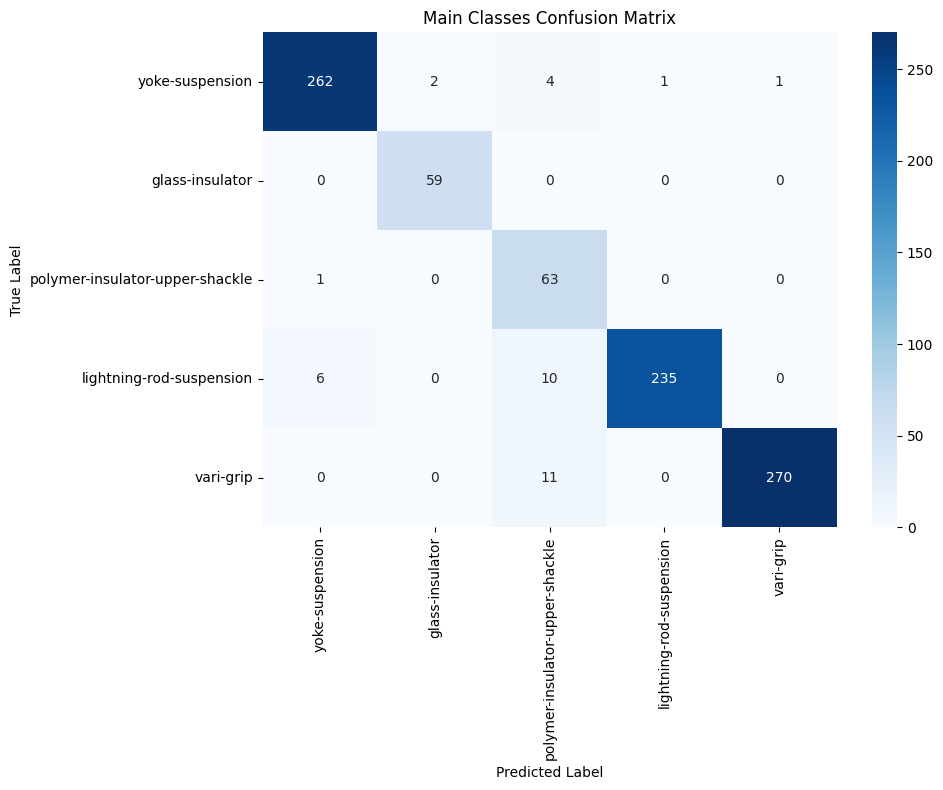

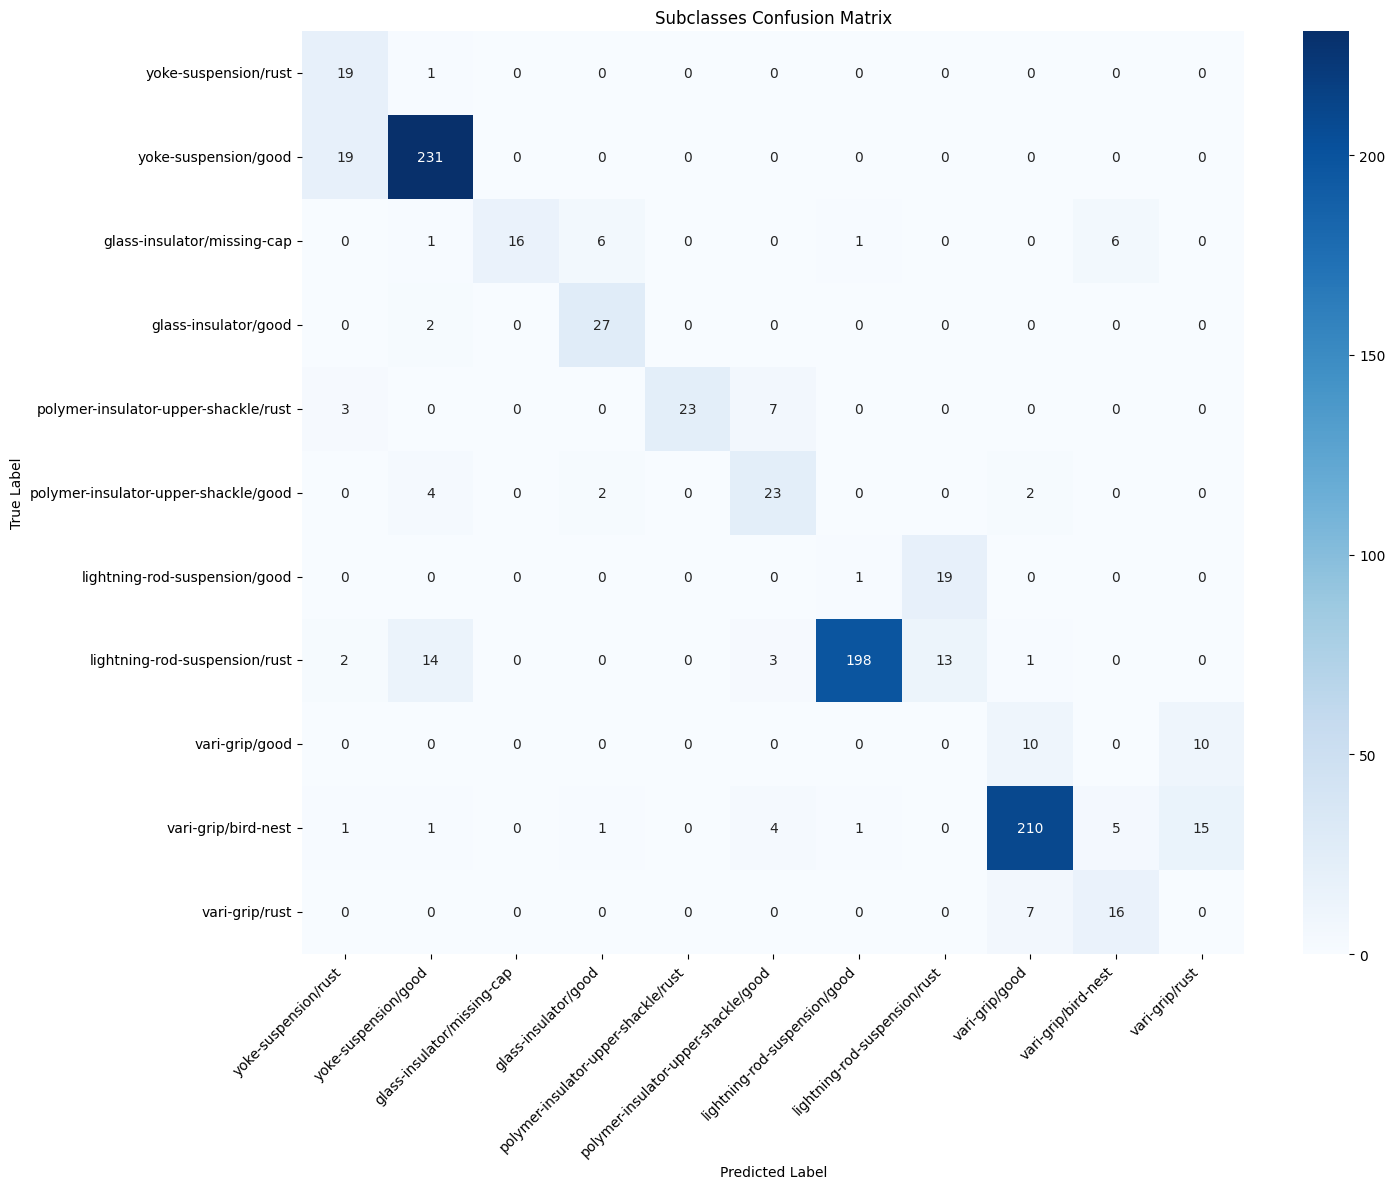

In [44]:
final_main_metrics = classifier.evaluate_model(val_loader, mode='main')
final_sub_metrics = classifier.evaluate_model(val_loader, mode='sub')
plot_final_matrices(classifier, final_main_metrics, final_sub_metrics)
print("\nFinal Performance Summary:")
print(f"Main Classification Accuracy: {final_main_metrics['accuracy']:.2f}%")
print(f"Subclass Classification Accuracy: {final_sub_metrics['accuracy']:.2f}%")

In [119]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.ops import boxes as box_ops
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F

def upscale_image(image, target_width=1500):
    """
    Upscale image while maintaining aspect ratio.

    Args:
        image: PIL Image
        target_width: Desired width for the upscaled image
    Returns:
        upscaled_image: PIL Image
    """
    # Get original dimensions
    original_width, original_height = image.size

    # Calculate scaling factor and new height
    scale_factor = target_width / original_width
    target_height = int(original_height * scale_factor)

    # Upscale image
    upscaled_image = image.resize((target_width, target_height), Image.Resampling.LANCZOS)

    return upscaled_image

def detect_objects(
    model,
    image_path,
    window_size=(224, 224),
    overlap=0.25,
    confidence_threshold=0.7,
    target_width=1500  # Target width for upscaling
):
    """
    Object detection with image upscaling.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Load and upscale image
    image = Image.open(image_path).convert('RGB')
    original_size = image.size

    # Upscale image
    image = upscale_image(image, target_width=target_width)
    scale_factor = target_width / original_size[0]

    print(f"Original size: {original_size}")
    print(f"Upscaled size: {image.size}")
    print(f"Scale factor: {scale_factor:.2f}")

    # Create transform for windows
    transform = transforms.Compose([
        transforms.Resize(window_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Calculate stride
    stride = int(min(window_size) * (1 - overlap))

    # Get upscaled dimensions
    width, height = image.size
    detections = []

    # Sliding window on upscaled image
    for y in range(0, height - window_size[1], stride):
        for x in range(0, width - window_size[0], stride):
            window = image.crop((x, y, x + window_size[0], y + window_size[1]))
            window_tensor = transform(window).unsqueeze(0).to(device)

            with torch.no_grad():
                try:
                    features = model.base(window_tensor)
                    output = model.main_classifier(features)
                    probs = torch.softmax(output, dim=1)

                    confidence, predicted_class = torch.max(probs, dim=1)
                    confidence = confidence.item()
                    predicted_class = predicted_class.item()

                    if confidence > confidence_threshold:
                        # Store coordinates in upscaled space
                        detections.append({
                            'bbox': [float(x), float(y),
                                    float(x + window_size[0]),
                                    float(y + window_size[1])],
                            'confidence': confidence,
                            'class': predicted_class
                        })
                except Exception as e:
                    print(f"Error processing window at ({x}, {y}): {e}")
                    continue

    # Apply NMS per class
    final_detections = []
    if detections:
        class_detections = {}
        for det in detections:
            cls = det['class']
            if cls not in class_detections:
                class_detections[cls] = []
            class_detections[cls].append(det)

        for cls in class_detections:
            boxes = torch.tensor([d['bbox'] for d in class_detections[cls]],
                               dtype=torch.float32, device=device)
            scores = torch.tensor([d['confidence'] for d in class_detections[cls]],
                                dtype=torch.float32, device=device)

            keep = box_ops.nms(boxes, scores, iou_threshold=0.45)
            keep = keep.cpu()

            for idx in keep[:5]:
                final_detections.append(class_detections[cls][idx])

    return final_detections, image

def draw_detections(image, detections, idx_to_class=None, output_path=None):
    """
    Draw bounding boxes on upscaled image.
    """
    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)

    # Calculate font size based on image width
    font_size = int(image.size[0] * 0.02)  # Proportional font size
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    colors = {
        0: (0, 255, 0),    # Green for glass insulators
        1: (255, 0, 0),    # Red for polymer insulators
        2: (0, 0, 255),    # Blue for ceramic insulators
        3: (255, 255, 0),  # Yellow for other components
        4: (255, 0, 255)   # Magenta for other classes
    }

    # Calculate border width based on image size
    border_width = max(4, int(image.size[0] * 0.003))

    for det in detections:
        bbox = [int(x) for x in det['bbox']]
        conf = det['confidence']
        class_idx = det['class']

        color = colors.get(class_idx, (255, 255, 255))

        # Draw thick rectangle
        for i in range(border_width):
            draw.rectangle([
                bbox[0]-i, bbox[1]-i,
                bbox[2]+i, bbox[3]+i
            ], outline=color, width=2)

        # Prepare label
        class_name = f"Class {class_idx}" if idx_to_class is None else idx_to_class[class_idx]
        label = f"{class_name} ({conf:.2f})"

        # Calculate text position and size
        text_offset = int(image.size[1] * 0.02)
        text_bbox = draw.textbbox((bbox[0], max(0, bbox[1]-text_offset)),
                                label, font=font)
        draw.rectangle(text_bbox, fill='black')
        draw.rectangle(text_bbox, outline=color, width=2)

        # Draw text
        draw.text((bbox[0], max(0, bbox[1]-text_offset)),
                 label, fill=color, font=font)

    if output_path:
        img_draw.save(output_path, quality=95)

    return img_draw

def detect_and_display(model, image_path, idx_to_class=None, output_path=None, target_width=1500):
    """
    Complete pipeline with upscaling.
    """
    print("Starting detection...")

    detections, upscaled_image = detect_objects(
        model=model,
        image_path=image_path,
        window_size=(224, 224),
        overlap=0.25,
        confidence_threshold=0.7,
        target_width=target_width
    )

    print(f"Found {len(detections)} objects")
    annotated_image = draw_detections(
        upscaled_image,
        detections,
        idx_to_class=idx_to_class,
        output_path=output_path
    )

    # Print results
    print("\nDetections (sorted by confidence):")
    sorted_detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    for i, det in enumerate(sorted_detections, 1):
        class_name = f"Class {det['class']}" if idx_to_class is None else idx_to_class[det['class']]
        print(f"{i}. {class_name} with confidence {det['confidence']:.2f}")

    return annotated_image

Starting detection...
Original size: (1920, 1080)
Upscaled size: (800, 450)
Scale factor: 0.42
Found 5 objects

Detections (sorted by confidence):
1. glass-insulator with confidence 0.99
2. glass-insulator with confidence 0.97
3. glass-insulator with confidence 0.93
4. glass-insulator with confidence 0.91
5. glass-insulator with confidence 0.90


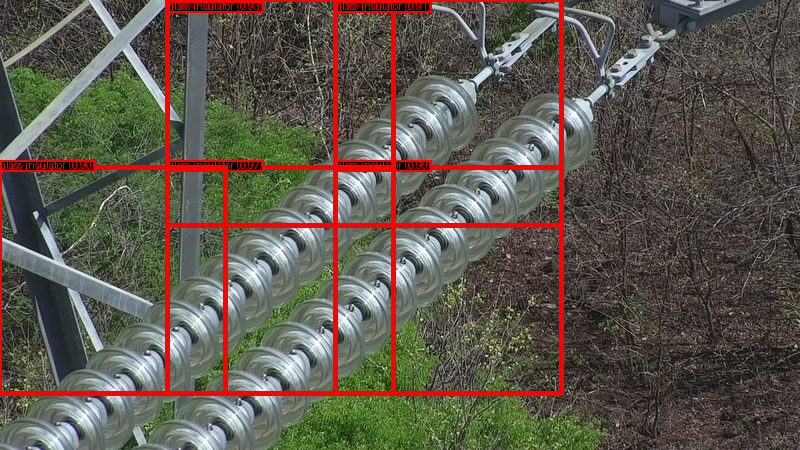

Starting detection...
Original size: (1920, 1080)
Upscaled size: (800, 450)
Scale factor: 0.42
Found 2 objects

Detections (sorted by confidence):
1. yoke-suspension with confidence 0.79
2. yoke-suspension with confidence 0.77


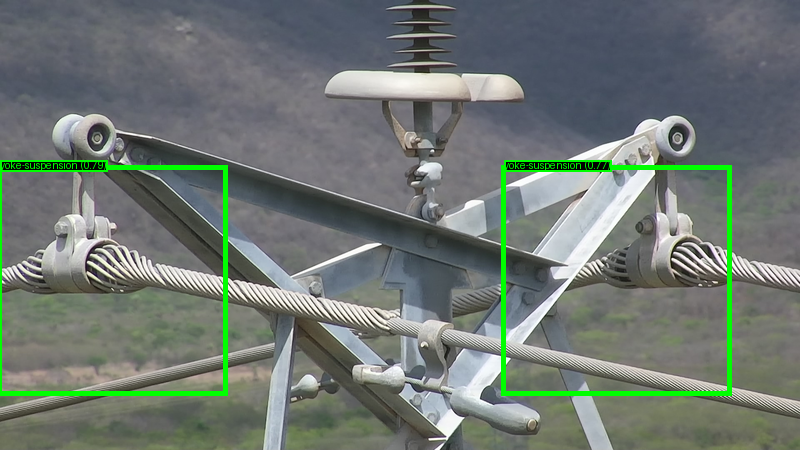

Starting detection...
Original size: (1012, 1012)
Upscaled size: (800, 800)
Scale factor: 0.79
Found 1 objects

Detections (sorted by confidence):
1. yoke-suspension with confidence 0.74


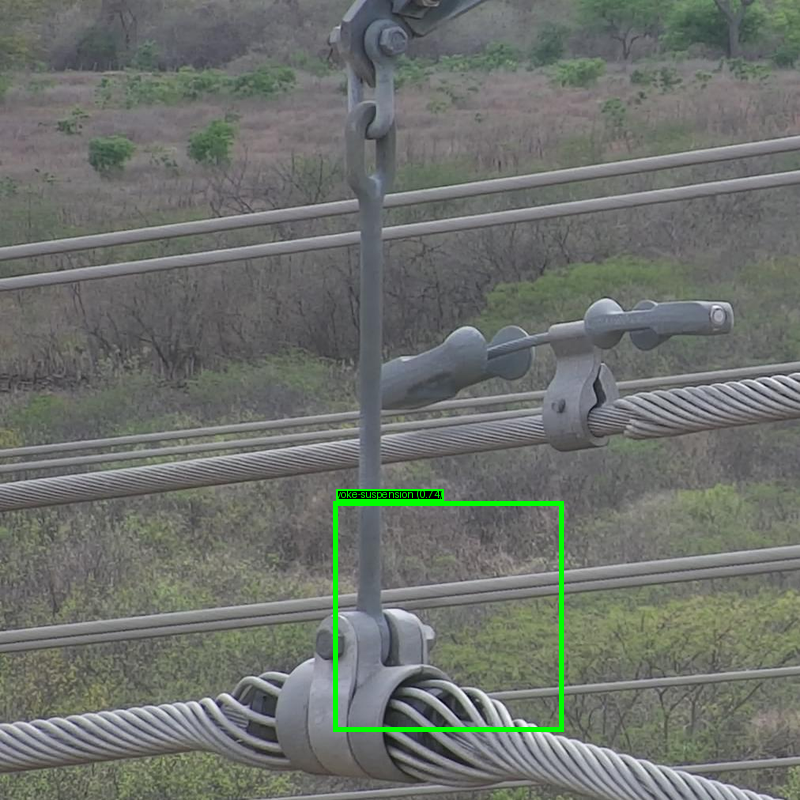

Starting detection...
Original size: (1920, 1080)
Upscaled size: (800, 450)
Scale factor: 0.42
Found 2 objects

Detections (sorted by confidence):
1. vari-grip with confidence 0.84
2. vari-grip with confidence 0.78


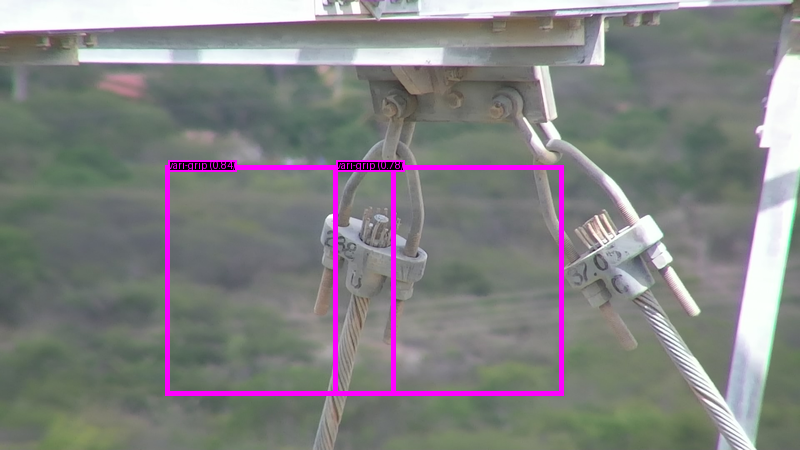

In [120]:
idx_to_class = {v: k for k, v in classifier.main_class_to_idx.items()}

for name in ['292-1_DJI_0158.jpg','238-1_DJI_0383.jpg', 'Fotos 01-12-2020_DJI_0020_amarra_balancim_337.jpg','238-1_DJI_0386.jpg']:
  annotated_image = detect_and_display(
      model=classifier.model,
      image_path=f'drive/MyDrive/insplad/{name}',
      idx_to_class=idx_to_class,
      output_path='output_image.jpg',
      target_width=800
  )
  display(annotated_image)

